# 2. Analysis

## Setup

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

sp = spacy.load('en_core_web_sm')
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [10, 7]

### Import dataset

In [88]:
data = pd.read_csv("../data/extremely_clean_dataset.csv") 

# Keep the first 1000 elements to reduce the load on cpu
data_debug = data[:1000]
data.head()

,review,sentiment
0,reviewer mention watch episode hook right exac...,positive
1,wonderful little production technique very una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy think zombie close...,negative
4,petter love time money visually stunning film ...,positive


## 2.1 EDA

In [89]:
data.describe()

,review,sentiment
count,50000,50000
unique,49569,2
top,love variety not solely cook great very captiv...,negative
freq,5,25000


In [90]:
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [91]:
base_rate = max(data['sentiment'].value_counts()) / data.shape[0]
print("Base rate: {}".format(base_rate))

Base rate: 0.5


#### Tokenizer

In [93]:
nlp = spacy.lang.en.English()

def tokenize_review(this_review):
    return [token.text for token in nlp(this_review)]

### 2.2.1 Logistic Model

In [114]:
X = data_debug['review']
y = data_debug['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [115]:
# We're looking for the value C that gives the highest accuracy

accuracy_by_c = []
for C in [0.01, 0.05, 0.25, 0.5, 1]:
    classifier = LogisticRegression(solver="saga", max_iter=2000, C=C)

    count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1,2))

    # Create pipeline using Bag of Words
    pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

    # Fit Model
    pipe.fit(X_train,y_train)

    accuracy = pipe.score(X_test, y_test)
    print("Accuracy for C={}: {}".format(C, accuracy))
    accuracy_by_c.append({'c': c, 'accuracy': accuracy})

Accuracy for C=0.01: 0.825
Accuracy for C=0.05: 0.855
Accuracy for C=0.25: 0.86
Accuracy for C=0.5: 0.855
Accuracy for C=1: 0.855


In [ ]:
plt.plot([point['c'] for point in accuracy_by_c], [point['accuracy'] for point in accuracy_by_c])

0.25 is highest, perform logistic regression on whole dataset

In [112]:
X = data['review'] 
y = data['sentiment'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

# Notes: - saga is better than lbfgs for large datasets
#        - at default max_iter (1000) the model doesn't converge, 2000 works
classifier = LogisticRegression(solver="lbfgs", C=0.25, max_iter=2000)

count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1, 2))

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

# Fit Model
pipe.fit(X_train,y_train)

pipe.score(X_test, y_test)

0.8987

#### Logistic Regression using TF-IDF

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize_review, ngram_range = (1, 2))
pipe = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', classifier)])

pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)

0.8687

#### Logistic Regression using SVM


In [110]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(C=0.25, max_iter=2000)
count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1, 2))

pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)

0.8916

### Strongest Coefficients

In [40]:
def get_interesting_features(features):
    interesting_coefs = []
    for best_positive in sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]:
        interesting_coefs.append(best_positive)

    for best_negative in sorted(features.items(), key=lambda x: x[1])[:5]:
        interesting_coefs.append(best_negative)
    return interesting_coefs

In [41]:
def graph_interesting_features(interesting_features):
    sorted_by_coef = sorted(interesting_features, key=lambda tup: tup[1], reverse=True)

    feature = [elem[0] for elem in sorted_by_coef]
    coef = [elem[1] for elem in sorted_by_coef]

    plt.bar(feature, coef)
    plt.xticks(feature, fontsize=12)
    plt.xticks(rotation=30)
    plt.show()

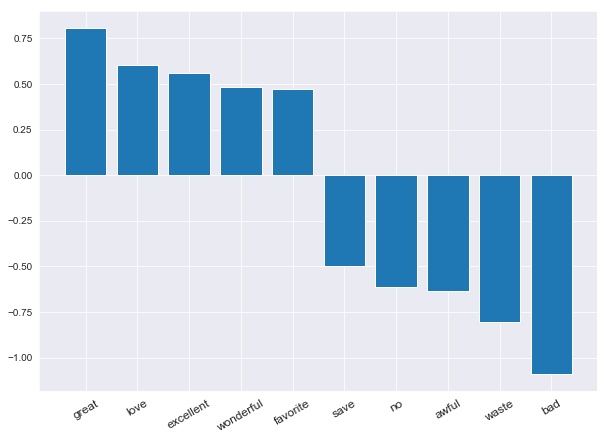

In [42]:
model_features = {
    word: coef for word, coef in zip(
        count_vector.get_feature_names(), classifier.coef_[0]
    )
}

interesting_features = get_interesting_features(model_features)
graph_interesting_features(interesting_features)

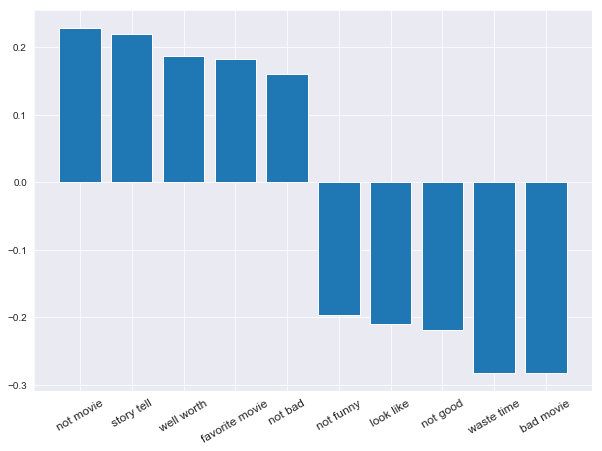

In [43]:
two_gram_features = {key: model_features[key] for key in model_features.keys() if len(key.split(' ')) == 2}
intersting_features = get_interesting_features(two_gram_features)
graph_interesting_features(intersting_features)

#### Results

In [44]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = pipe.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.83      0.88      0.86        98
    positive       0.88      0.83      0.85       102

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.86      0.85      0.85       200



#### Confusion matrix

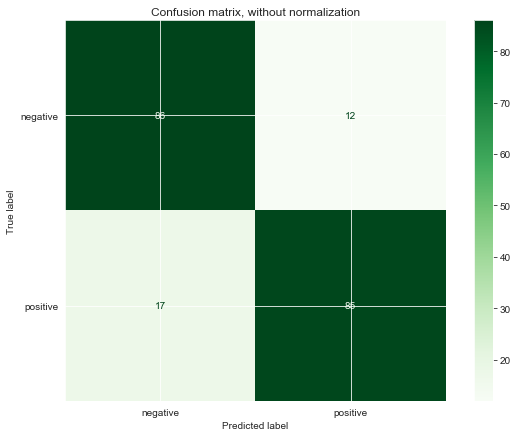

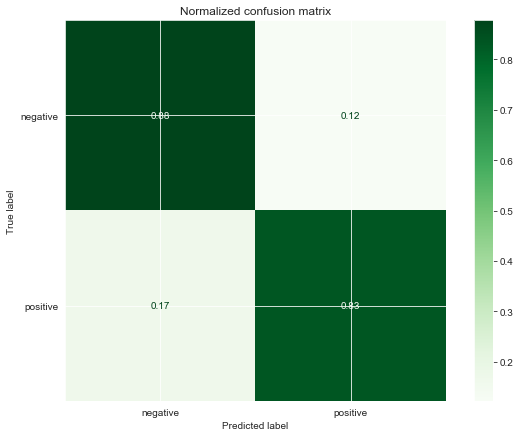

In [45]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

#### Precision Recall Curve


Average precision-recall score: 0.92


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.92')

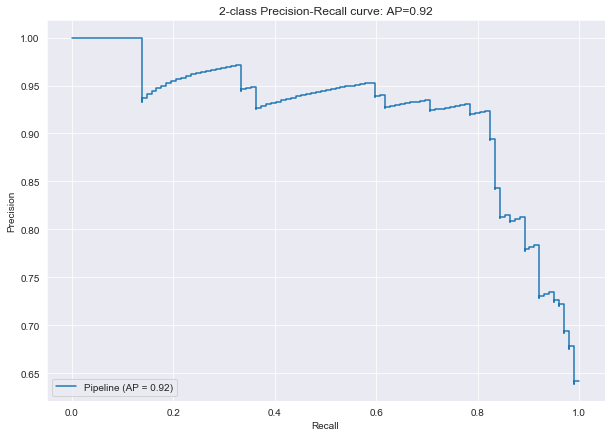

In [46]:
y_score = pipe.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score, pos_label="positive")

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 2.2.2 Decision Trees

In [47]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [48]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [49]:
tree.score(X_test,y_test)

0.695

In [50]:
tree.get_depth()

10

#### Tuning the depth of the tree

In [51]:
#scores = []
#for d in range(1, 21):
#    test_tree = DecisionTreeClassifier(criterion='entropy', max_depth=d)
#    test_tree.fit(X_train, y_train)
#    scores.append(test_tree.score(X_test, y_test))

In [52]:
#plt.plot(scores)
#plt.ylabel('accuracy', fontsize=15)
#plt.xlabel('depth', fontsize=15)

[Text(379.72041984732823, 363.22363636363633, 'X[4862] <= 0.5\nentropy = 1.0\nsamples = 800\nvalue = [401, 399]'),
 Text(265.33396946564886, 328.6309090909091, 'X[81988] <= 0.5\nentropy = 0.966\nsamples = 562\nvalue = [220, 342]'),
 Text(211.20229007633586, 294.0381818181818, 'X[4667] <= 0.5\nentropy = 0.944\nsamples = 529\nvalue = [191, 338]'),
 Text(159.73282442748092, 259.44545454545454, 'X[31402] <= 0.5\nentropy = 0.927\nsamples = 511\nvalue = [175, 336]'),
 Text(90.87022900763358, 224.85272727272724, 'X[46602] <= 0.5\nentropy = 0.973\nsamples = 365\nvalue = [147, 218]'),
 Text(79.51145038167938, 190.26, 'X[30626] <= 0.5\nentropy = 0.961\nsamples = 354\nvalue = [136, 218]'),
 Text(56.79389312977099, 155.6672727272727, 'X[7622] <= 0.5\nentropy = 0.946\nsamples = 341\nvalue = [124, 217]'),
 Text(45.43511450381679, 121.07454545454544, 'X[84079] <= 0.5\nentropy = 0.934\nsamples = 334\nvalue = [117, 217]'),
 Text(34.07633587786259, 86.48181818181814, 'X[60407] <= 0.5\nentropy = 0.952\ns

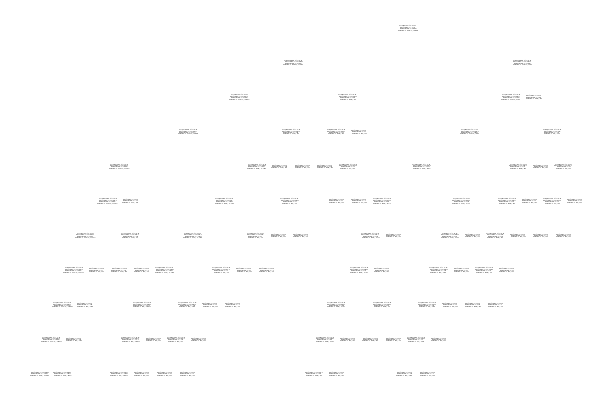

In [53]:
from sklearn.tree import plot_tree

plot_tree(tree)

In [54]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = tree.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.77      0.54      0.63        98
    positive       0.66      0.84      0.74       102

    accuracy                           0.69       200
   macro avg       0.71      0.69      0.69       200
weighted avg       0.71      0.69      0.69       200



#### Confusion matrix

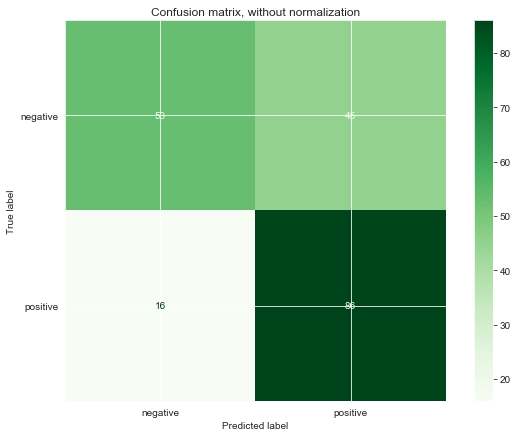

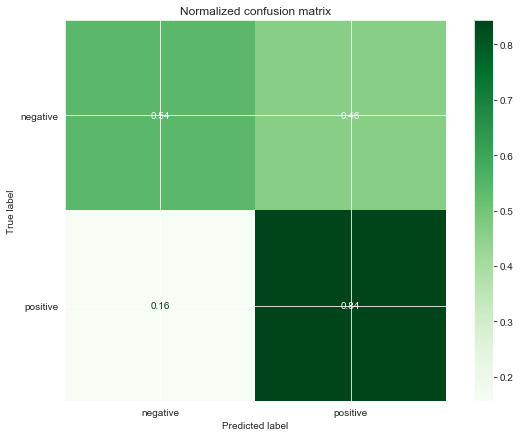

In [55]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

###  2.2.3 KNN Classification

In [56]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [57]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [58]:
knn.score(X_test, y_test)

0.64

In [59]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = knn.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.67      0.52      0.59        98
    positive       0.62      0.75      0.68       102

    accuracy                           0.64       200
   macro avg       0.65      0.64      0.63       200
weighted avg       0.65      0.64      0.63       200



#### Tuning the value of n

In [60]:
#scores = []
#for n in range(1, 21):
#    knn = KNeighborsClassifier(n_neighbors=n, weights='uniform')
#    knn.fit(X_train, y_train)
#    scores.append(knn.score(X_test, y_test))

In [61]:
#plt.plot(scores)
#plt.ylabel('accuracy', fontsize=15)
#plt.xlabel('N', fontsize=15)

#### Confusion matrix

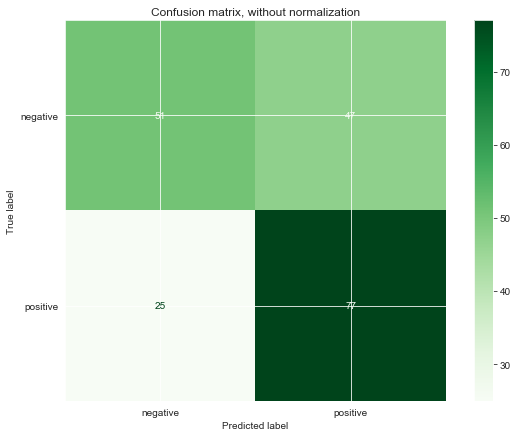

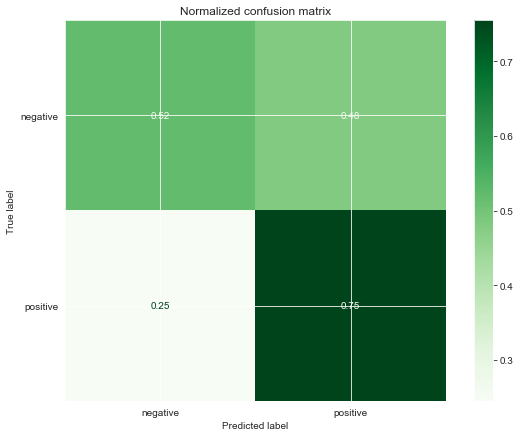

In [62]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

# 2.3. Conclusion and Recommendation

From the analysis shown above we can see that the best performing method of classification of the reviews into binary class positive/negative is Logistic Regression method......